<a href="https://colab.research.google.com/github/ParameshMalla/dataSciencePractiseNotebooks/blob/main/MNISTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing and Testing MNIST data

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.datasets import fetch_openml
numbers = fetch_openml('mnist_784', version=1)

In [3]:
type(numbers)

sklearn.utils.Bunch

In [4]:
numbers.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
numbers['data'].shape

(70000, 784)

In [6]:
numbers['target'].shape

(70000,)

In [7]:
X, y = numbers['data'], numbers['target']

In [8]:
i = np.random.randint(0,70000)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

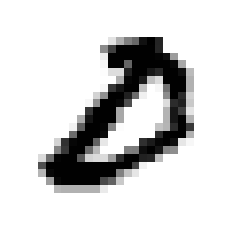

In [10]:
randigit = X[i]
randigit_image = randigit.reshape(28,28)

plot_digit(randigit)

In [11]:
y[i]

'0'

In [12]:
type(y[i])

str

In [13]:
y = y.astype(np.uint8)

The MNIST dataset is  already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [15]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [16]:
from sklearn.linear_model import SGDClassifier

bin_sgd = SGDClassifier(random_state = 42)
bin_sgd.fit(X_train,y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
bin_sgd.predict([randigit])

array([False])

###Performance Measures

Measuring Accuracy Using Cross-Validation

In [18]:
#Custom CV set
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(bin_sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_9[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_9[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.94065
0.94405
0.94885


Precision Recall and F<sub>1</sub>

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(bin_sgd, X_train, y_train_9, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]])

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_9, y_train_pred))
print(recall_score(y_train_9, y_train_pred))
print(f1_score(y_train_9, y_train_pred))

0.7610017889087657
0.7150781643973777
0.737325591472398


Use decision_function() parameter to change the threshold

In [22]:
y_scores = cross_val_predict(bin_sgd, X_train, y_train_9, cv=3,
                             method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

In [24]:
len(y_scores)

60000

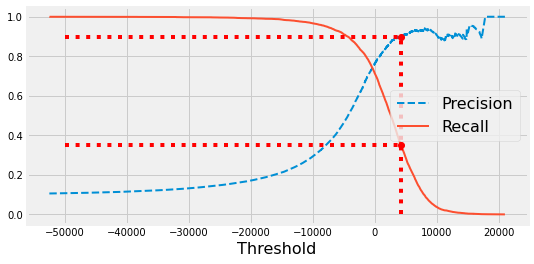

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "--", label="Precision", linewidth=2)          # Last precision is 1
    plt.plot(thresholds, recalls[:-1], "-", label="Recall", linewidth=2)                 # Last recall is 0
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

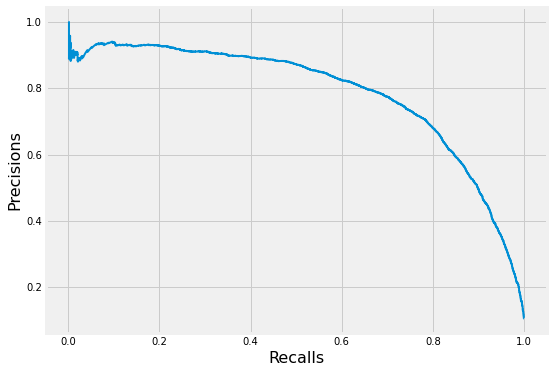

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions,linewidth=2)
    plt.xlabel('Recalls', fontsize=16)
    plt.ylabel('Precisions', fontsize=16)
    

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC Curve

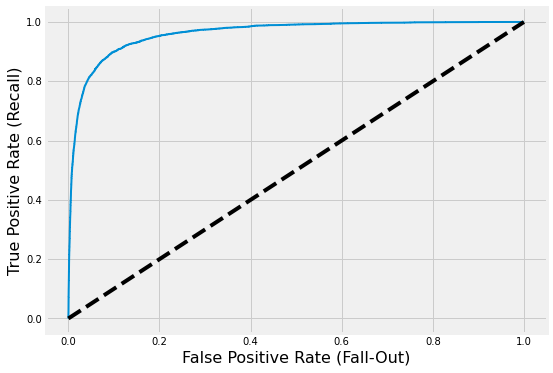

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
                                        # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_9, y_scores)

0.96114559368217

In [29]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3,
                                    method="predict_proba")

In [30]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9,y_scores_forest)

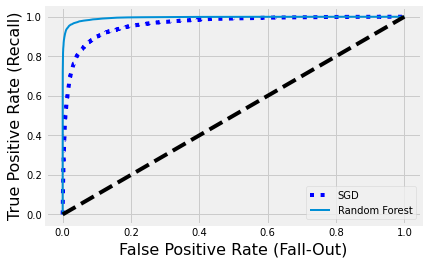

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [32]:
roc_auc_score(y_train_9, y_scores_forest)

0.9952328942154235

### Multiclass Classification

In [33]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([randigit])

array([0], dtype=uint8)

In [34]:
randigt_scores = svm_clf.decision_function([randigit])
randigt_scores

array([[ 9.31098083,  2.70802224,  8.30328402,  6.28197992,  0.69383077,
         4.26220563,  5.19225371, -0.3088637 ,  7.29186847,  1.69532598]])

In [35]:
np.argmax(randigt_scores)

0

In [36]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [38]:
from sklearn.model_selection import cross_val_score

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.977 , 0.9738, 0.9739])

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(svm_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9596, 0.9602, 0.961 ])

In [ ]:
y_train_svcpred = cross_val_predict(svm_clf,X_train,y_train,cv=3)
conf_m = confusion_matrix(y_train,y_train_svcpred)
conf_m